# Pairs Trading

This strategy is based in selecting pairs of assets (with high correlation) that together form a mean-reversion process
\begin{eqnarray}
\displaystyle X_t = a_1 S_t^{(1)} + a_2 S_t^{(2)} \\
\displaystyle dX_t = \mu (\theta - X_t)dt + \sigma dW_t
\end{eqnarray}
And the strategy consists in that the price is eventually reverting to the mean, so higher prices than the average $\theta$ means sell, and lower values than $\theta$ mean buy.

A easy strategy:\\
Having spotted assets with high correlation, then the change in the difference in price between the two stocks can be used to signal trading events if one of the two moves out of correlation with the other.

Thus, if the change in the spread between the two stocks exceeds a certain level (their
correlation has decreased), then the higher-priced stock is signalled to sell as it is assumed that the spread. In the same way, the lower-priced stock is signalled to buy. The strategy is assumed to sell and buy the same amounts of each stock and profiting as the two prices move back into correlation. {\bf This strategy relies on the two assets being correlated}.

Let's examine an example with two companies in the same industry:
\begin{figure}
\centering
\begin{tikzpicture}
\node(graph) at (0,0) {\includegraphics[scale=.75]{Pairstrading-crop.pdf}};
\draw[<-, thick, red] (-2.1,-1) -- (-2.5,1.5);
\draw[red] (-1.3,1.5) node[above]{Spread in Correlation}; 
\draw[<-, thick, red] (0.2,-1) -- (-0.5,1.5); 
\end{tikzpicture}
\end{figure} 

Next, the code to generate the graph:
\begin{lstlisting}[language=python]
# Download Data for Toyota and suzuki for 2016
# tckrs = ['HMC', 'TM', 'MZDAY', 'SZKMY', 'YAMHF', 'FUJHY', 'NSANY']
tckrs = ['TM', 'SZKMY']
tck_data = oget(tckrs,datetime(2016, 1, 1),datetime(2017, 1, 1))
all_clspx = tck_data[['Adj Close']].reset_index()
daily_px = all_clspx.pivot('Date', 'Ticker','Adj Close')

#####	Plot the timeseries	################
daily_px.plot()
plt.show()
\end{lstlisting}

For this strategy we have two underlying securities $X$ and $Y$ that should be correlated (for example companies in the same sector of industry). We point out two remarks:
\begin{enumerate}
\item We expect the spreads to be constant (some sort of constant).
\item When the prices diverge from this constant spread is the time to invest. Since, as soon as they revert we made a profit. 

The first most difficult step for this strategy is to find two highly correlated assets (and that will be correlated in the future!), for the example code we use Toyota and Suzuki (fingers crossed).
\end{enumerate}

For pairs trading there is an important definition:
\begin{definition}
the time-series $X$ and $Y$ are {\bf co-integrated}  if 
\begin{equation}
\displaystyle X = \alpha Y + \epsilon
\end{equation}
where $\epsilon$ is a white noise (or a stationary process) and $\alpha$ some constant.
\end{definition}

For pairs trading to work we need two co-integrated process. In other words we must have between $X$ and $Y$ the relation
\[ \displaystyle \mathbb{E} \left[ \frac{X}{Y} \right] \to \alpha \]
\begin{lstlisting}[language=python]
TM_r = daily_px[['TM']]
SZK_r = daily_px[['SZKMY']]
TM_r.columns = ['p']
SZK_r.columns = ['p']
Divframe = SZK_r/TM_r
## Plot the Ratio
Divframe.plot() 
plt.axhline(Divframe.mean()[0], color='red', linestyle='--') 
plt.xlabel('Time')
plt.legend(['Price Ratio', 'Mean'])
plt.show()
\end{lstlisting}

Thus there is the need of a test for co-integration, fortunately \texttt{python} has in the library \texttt{statsmodels.data.statstools} a co-integration test (based on a ols and a Dickey-Fuller unity test), and we look for a small p-value.
\begin{lstlisting}[language=python]
# compute the p-value of the cointegration test:
# This informs us as to whether the ratio between the 2 timeseries is stationary around its mean
import statsmodels.tsa.stattools as ts
score, pvalue, _ = ts.coint(SZK_r,TM_r)
print pvalue
\end{lstlisting}
Note that correlation and co-integration are not the same.

Starting with two co-integrated series we create the process $\displaystyle \alpha_t = \frac{X_t}{Y_t}$ and calculate $\alpha_m$ as the mean of $\alpha_t$ over some window. The strategy then is:
\begin{enumerate}
\item Buy the ratio when $\alpha_t < \alpha_m$ (Since we expect $\alpha_t$ to increase). This means Buy $X$ and Sell $Y$.
\item Sell the ratio when $\alpha_t > \alpha_m$. This means Sell $X$ and Buy $Y$.
\end{enumerate}

{\bf Note.} Since we have a short position that makes money if the sold security losses value and the long position if the bought security gains value, in a mean reverting process we are hedged. The only way to loss money is if both securities move relative to each other. 

We are going to normalize the signal (mean $0$ and variance $1$), to add signals whenever the normalized ratio leaves $[-1,1]$, That is
\[ \displaystyle Zscore_t = \frac{\alpha_t - \alpha_m}{std(a_t)} \]
\begin{lstlisting}[language=python]
zscore = (Divframe - Divframe.mean()[0])/np.std(Divframe)
zscore.plot()
plt.axhline(zscore.mean()[0])
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()
\end{lstlisting}

As before an improvement arrives when we use windows , thus we will use a rolling average of $5$ days and $60$ days, to try and "predict" the future 
\begin{lstlisting}[language=python]
ratios_mavg5 = Divframe.rolling(window=5,center=False).mean()
ratios_mavg60 = Divframe.rolling(window=60,center=False).mean()
std_60 = Divframe.rolling(window=60,center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
\end{lstlisting}
plot the ratios
\begin{lstlisting}[language=python]
plt.figure()
plt.plot(Divframe.index, Divframe.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
plt.show()
\end{lstlisting}
Plot the Predicting zscore
\begin{lstlisting}[language=python]
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()
\end{lstlisting}
Finally the trading signal is:
\[ \displaystyle signal_t = \begin{cases} zscore > 1 & \text{Sell the ratio} \\ zscore<-1 & \text{Buy the ratio} \end{cases} \] 
\begin{lstlisting}[language=python]
buy = zscore_60_5.copy()
sell = zscore_60_5.copy()
buy[zscore_60_5>-1] = np.nan
sell[zscore_60_5<1] = np.nan
\end{lstlisting}
And plot
\begin{lstlisting}[language=python]
plt.figure()
plt.plot(zscore_60_5[60:].index, zscore_60_5[60:].values)
plt.plot(buy[60:].index, buy[60:].values, color='g', linestyle='None', marker='^')
plt.plot(sell[60:].index, sell[60:].values, color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,zscore_60_5.min()[0],zscore_60_5.max()[0]))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()
\end{lstlisting}
Next we create the buying and selling signals on the actual signals for $X$ and $Y$
\begin{lstlisting}[language=python]
X = SZK_r
Y = TM_r
buyR = 0*X.copy()
sellR = 0*X.copy()
# When buying the ratio, buy X and sell Y
buyR[buy['p'].notnull()] = X[buy['p'].notnull()]
sellR[buy['p'].notnull()] = Y[buy['p'].notnull()]
# When selling the ratio, sell X and buy Y 
buyR[sell['p'].notnull()] = Y[sell['p'].notnull()]
sellR[sell['p'].notnull()] = X[sell['p'].notnull()]
\end{lstlisting}
and plot them
\begin{lstlisting}[language=python]
X = SZK_r
Y = TM_r
buyR = 0*X.copy()
sellR = 0*X.copy()
# When buying the ratio, buy X and sell Y
buyR[buy['p'].notnull()] = X[buy['p'].notnull()]
sellR[buy['p'].notnull()] = Y[buy['p'].notnull()]
# When selling the ratio, sell X and buy Y 
buyR[sell['p'].notnull()] = Y[sell['p'].notnull()]
sellR[sell['p'].notnull()] = X[sell['p'].notnull()]
\end{lstlisting}
Finally you should be able to calculate the returns of this strategy and plot them!!

Since the key point is how to find the correct assets, we should compare different asset pairs to get the best possible pair (different that the correct pair).

There is a comparison bias if we compare too much assets (Seek and ye shall find). 

If we have a list of securities and want to obtain the co-integrated pairs (if any), we follow the next function (which is adapted from Quantopian) 
\begin{lstlisting}[language=python]
# Quantopian function to compare pairs of securities; modified to use pd.DataFrame
def find_cointegrated_pairs(securities):
    n = len(securities.columns)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = securities.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = securities[keys[i]]
            S2 = securities[keys[j]]
            result = ts.coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
              pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs
\end{lstlisting}
And use it as:
\begin{lstlisting}[language=python]
tckrs = ['HMC', 'TM', 'MZDAY', 'SZKMY', 'YAMHF', 'FUJHY', 'NSANY']
tck_data = oget(tckrs,datetime(2016, 1, 1),datetime(2017, 1, 1))
all_clspx = tck_data[['Adj Close']].reset_index()
daily_px = all_clspx.pivot('Date', 'Ticker','Adj Close')
scores, pvalues, pairs = find_cointegrated_pairs(daily_px)
\end{lstlisting}
In the variable \texttt{pairs}, there are the co-integrated pairs $95\%$ confidence.

To plot we use a heat map:
\begin{lstlisting}[language=python]
import seaborn
print pvalues
print pairs
seaborn.heatmap(pvalues, xticklabels=tckrs, yticklabels=tckrs, cmap='RdYlGn_r', mask = (pvalues >= 0.98))
plt.show()
\end{lstlisting}


# Inicio de Funciones

En esta sección se encuentran todas las funciones necesarias para ejecutar la estrategia y su respectivo backtesting.

In [0]:
import numpy as np
import pandas as pd
from pandas_datareader import data
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.tsa.stattools as ts
import warnings
warnings.filterwarnings("ignore")

In [0]:
#Function to obtain data from, yahoo
def odata(ticker, start, end):
    return data.DataReader(ticker, 'yahoo', start, end)

## Fetching function
def oget(tickers, start, end):
    Alldata = []
    for t in tickers:
        rdata = odata(t,start,end)
        Alldata.append(rdata)
    return pd.concat(Alldata, keys=tickers, names=['Ticker','Date'])

  
# Quantopian function to compare pairs of securities; modified to use pd.DataFrame
def find_cointegrated_pairs(securities,window):
    n = len(securities.columns)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = securities.columns
    pairs = []
    pvof = []
    for i in range(n):
        for j in range(n):
          if i != j:
              S1 = securities[keys[i]][-window:]
              S2 = securities[keys[j]][-window:]
              result = ts.coint(S1, S2)
              score = result[0]
              pvalue = result[1]
              score_matrix[i, j] = score
              pvalue_matrix[i, j] = pvalue
              if pvalue < .1 and not([keys[i],keys[j]][::-1] in pairs):
                pairs.append([keys[i], keys[j]])
              #pvof.append((keys[i], keys[j],pvalue))

    return score_matrix, pvalue_matrix, pairs

# Genera las distintas trayectorias de precios 
def gen_paths(S0, r, sigma, W, I):
    dt = float(1) / W
    paths = np.zeros((W + 1, I), np.float64)
    paths[0] = S0
    for t in range(1, W + 1):
        rand = np.random.standard_normal(I)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * rand)
    return paths


# Genera el gráfico de la distribución del p-valor dado que el precio se comporta aleatoriamente a partir de last_date
  # siempre window > w_p_value
def p_value_stability(pair_tickers, last_date, numb_paths, window, w_p_value):
  T = int(window / 3)
  date_t = last_date
  date_0 = date_t - timedelta(days=window)
  tck_data = odata(pair_tickers, date_0,date_t)
  clspx = tck_data[['Adj Close']]
  keys = clspx.columns
  r_a = np.log(clspx[keys[0]]).mean() / window
  r_b = np.log(clspx[keys[1]]).mean() / window
  sigma_a = np.log(clspx[keys[0]]).std()
  sigma_b = np.log(clspx[keys[1]]).std()
  paths_a = pd.DataFrame(gen_paths(clspx[keys[0]][0], r_a, sigma_a, T ,numb_paths))
  paths_b = pd.DataFrame(gen_paths(clspx[keys[1]][0], r_b, sigma_b, T ,numb_paths))
  pvalue_l = []
  for p in paths_a.columns:
    for q in paths_b.columns:
      S1 = pd.Series(np.concatenate((clspx[keys[0]].values, paths_a[p].values)))[-w_p_value:]
      S2 = pd.Series(np.concatenate((clspx[keys[1]].values, paths_a[q].values)))[-w_p_value:]
      result = ts.coint(S1, S2)
      pvalue_l.append(result[1])
  '''
  sns.distplot(pd.DataFrame(pvalue_l), hist=True, kde=True, 
              bins=int(50), color = 'darkblue', 
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 2})'''
  #sns.set();
  plt.figure(figsize=(12,4))
  sns.distplot(pvalue_l, bins = numb_paths*10)
  plt.title(keys[0][1] + ' / ' + keys[1][1] + ' || ' + 'Window = '+str(w_p_value))
  plt.show();
  #print(pd.DataFrame(pvalue_l).mean()[0], pd.DataFrame(pvalue_l).max()[0])


def pair_test(pair_tickers, last_date):
  date_t = last_date
  date_0 = date_t - timedelta(days=252*3)
  tck_data = odata(pair_tickers, date_0,date_t)
  clspx = tck_data[['Adj Close']]
  keys = clspx.columns
  p_v = []
  for tau in [126,252,126+252,252*2]:
    S1 = clspx[keys[0]][-tau:]
    S2 = clspx[keys[1]][-tau:]
    p_v.append((tau,ts.coint(S1, S2)[1]))
  return pd.DataFrame(p_v, columns = ['Window (d)',keys[0][1]+' / '+keys[1][1]])

# w_t > w_T ,..., w_T < window
def pair_evaluation(pair_tickers, last_date, trigger, w_t, w_T, numb_paths ,window, w_p_value, stability):
  date_t = last_date
  date_0 = date_t - timedelta(days=window)
  tck_data = oget(pair_tickers, date_0,date_t)
  clspx = tck_data[['Adj Close']].reset_index()
  px = clspx.pivot('Date', 'Ticker','Adj Close')
  keys = px.columns
  a_b = pair_test(pair_tickers, last_date)
  b_a = pair_test(pair_tickers[::-1], last_date)
  display(pd.merge(a_b,b_a,'inner','Window (d)').set_index('Window (d)'))
  if stability == 'Y':
    p_value_stability(pair_tickers, last_date, numb_paths, window, w_p_value)

  if (a_b.iloc[:,1] < .1).astype(int).sum() >= (b_a.iloc[:,1] < .1).astype(int).sum():
    px['ratio'] = px[keys[0]] / px[keys[1]]
    name = a_b.columns[1]
  else:
    px['ratio'] = px[keys[1]] / px[keys[0]]
    name = b_a.columns[1]

  px['ma_t'] = px['ratio'].rolling(window=w_t,center=False).mean()
  px['ma_T'] = px['ratio'].rolling(window=w_T,center=False).mean()
  px['mstd_T'] = px['ratio'].rolling(window=w_T,center=False).std()
  px['z_score'] = (px['ma_t'] - px['ma_T']) / px['mstd_T']
  buy = px['z_score'].copy()
  sell = px['z_score'].copy()
  buy[px['z_score']>-trigger] = np.nan
  sell[px['z_score']<trigger] = np.nan
  S1 = px[name.split(' / ')[0]]
  S2 = px[name.split(' / ')[1]]
  buyR = 0*S1.copy()
  sellR = 0*S1.copy()
  buyR[buy.notnull()] = S1[buy.notnull()]
  sellR[buy.notnull()] = S2[buy.notnull()]
  buyR[sell.notnull()] = S2[sell.notnull()]
  sellR[sell.notnull()] = S1[sell.notnull()]
  buyR = buyR.replace([0],[np.nan])
  sellR = sellR.replace([0],[np.nan])
  plt.figure(figsize=(12,6))
  S1.plot(color = 'c')
  S2.plot(color = 'grey')
  sellR.plot(color='r', linestyle='None', marker='v')
  buyR.plot(color='g', linestyle='None', marker='^')
  plt.legend([name.split(' / ')[0], name.split(' / ')[1], 'Short Signal','Long Signal'])
  plt.title(name)
  plt.show();
  plt.figure(figsize=(12,4))
  px['z_score'].plot()
  sell.plot(color='r', linestyle='None', marker='v')
  buy.plot(color='g', linestyle='None', marker='^')
  plt.axhline(trigger, color='red',linestyle='--')
  plt.axhline(-trigger, color='green',linestyle='--')
  plt.legend(['Z-Score','Short Signal','Long Signal'])
  plt.title(name)
  plt.show();


def bla(tckrs, start, end, window_hist, trigger, lim_trigger, stop_loss_trigger, take_prof_trigger, pos_size, max_expo, cash_0):
  cols = ['t','ID','TYPE','A','B','P_A_0','P_B_0','P_0','mu_0','std_0','par','Q_A','Q_B','z_0']
  open_ops = pd.DataFrame([], columns = cols)
  cols2 = ['t_apertura','t_cierre','ID','TYPE','A','B','P_A_0','P_B_0','Q_A','Q_B','P_A_T','P_B_T','NOMINAL']
  closed_ops = pd.DataFrame([], columns = cols2)
  port_val = cash_0
  cash = cash_0
  hist_cash = [(start, cash)]
  hist_port_val = [(start, port_val)]

  for ite in reversed(range((end - start).days)):  
    date_t0 = end - timedelta(days = ite)
    if not(date_t0.strftime("%A") in ['Saturday', 'Sunday']):
      date_t0_minus = date_t0 - timedelta(days = window_hist)
      tck_data = oget(tckrs, date_t0_minus, date_t0)
      all_clspx = tck_data[['Adj Close']].reset_index()
      daily_px = all_clspx.pivot('Date', 'Ticker','Adj Close')
      scores, pvalues, pairs = find_cointegrated_pairs(daily_px, window_hist)
      pairs_ch = []
      # (0) Establecer que pares estan en condiciones para ser operados: Input para la sección de Reglas
      for par in pairs:
        ppar = daily_px[par[0]] / daily_px[par[1]]
        mu = ppar.mean()
        std = ppar.std()
        pa = daily_px[par[0]][-1]
        pb = daily_px[par[1]][-1]
        px = ppar[-1]
        z = ( px - mu ) / std
        if (trigger <= abs(z) <= lim_trigger) and (len(open_ops[open_ops['par'] == par[0]+'-'+par[1]]) == 0 and len(open_ops[open_ops['par'] == par[1]+'-'+par[0]]) == 0):     # NO SE REPITEN PARES
          pairs_ch.append((par, px, mu, std, z, pa, pb ))
      # (1) Apertura Operación: REGLAS
      if len(pairs_ch) > 0 and len(open_ops)*pos_size < max_expo:       # Existen pares operables y la exposición es menor que el parámetro de exposición máxima 
        for veri in pairs_ch:   
          if veri[4] > trigger and len(open_ops)*pos_size < max_expo:   # SHORT    
            pa = veri[5]
            pb = veri[6]
            px = veri[1]
            mu = veri[2]
            std = veri[3]
            q = int(cash_0*pos_size / (pa + pb))        
            idd = abs(int(np.random.normal(1,5)*1000000000))                                 
            info = [date_t0, idd, 'SHORT', veri[0][0], veri[0][1], pa, pb, px, mu, std, veri[0][0]+'-'+veri[0][1], -q, q,veri[4]]
            temp = pd.DataFrame(info).T
            temp.columns = cols
            open_ops = pd.concat([open_ops, temp])
            cash = cash - q * (pa + pb)
          if veri[4] < -trigger and len(open_ops)*pos_size < max_expo:   # LONG      
            pa = veri[5]
            pb = veri[6]
            px = veri[1]
            mu = veri[2]
            std = veri[3]
            q = int(cash_0*pos_size / (pa + pb))   
            idd = abs(int(np.random.normal(1,5)*1000000000))                                     
            info = [date_t0, idd, 'LONG', veri[0][0], veri[0][1], pa, pb, px, mu, std,veri[0][0]+'-'+veri[0][1], q, -q, veri[4]]
            temp = pd.DataFrame(info).T
            temp.columns = cols
            open_ops = pd.concat([open_ops, temp])
            cash = cash - q * (pa + pb)
        hist_cash.append((date_t0,cash))
      else:
        hist_cash.append((date_t0,cash))
      # (2) P & G posiciones abiertas
      if len(open_ops):
        px_last1 = pd.DataFrame(daily_px.iloc[-1]).reset_index()
        px_last1.columns = ['A','PX_LAST_A']
        px_last2 = px_last1.copy()
        px_last2.columns = ['B','PX_LAST_B']
        val_open_ops = pd.merge(pd.merge(open_ops, px_last1, 'left', 'A'), px_last2, 'left', 'B')
        val_open_ops['expo_0'] = (val_open_ops['P_A_0'] * abs(val_open_ops['Q_A'])) + (val_open_ops['P_B_0'] * abs(val_open_ops['Q_B']))
        val_open_ops['P&G'] = ((val_open_ops['PX_LAST_A'] - val_open_ops['P_A_0']) * val_open_ops['Q_A']) + ((val_open_ops['PX_LAST_B'] - val_open_ops['P_B_0']) * val_open_ops['Q_B'])
        val_open_ops['Port'] = val_open_ops['expo_0'] + val_open_ops['P&G']
        val_open_ops['z_last'] = ((val_open_ops['PX_LAST_A']/ val_open_ops['PX_LAST_B']) - val_open_ops['mu_0']) / val_open_ops['std_0']
        # Stop - Loss de las posiciones que se salen del umbral de tolerancia
        closed_sl = val_open_ops[(abs(val_open_ops['z_last']) > stop_loss_trigger) | (abs(val_open_ops['z_last']) <= take_prof_trigger)]
        hist_port_val.append((date_t0, val_open_ops['Port'].sum() + cash))
        pyg_real_sl = 0
        if len(closed_sl) > 0:
          open_ops = open_ops[~(open_ops['ID'].isin(closed_sl['ID'].tolist()))]
          val_open_ops = val_open_ops[~(val_open_ops['ID'].isin(val_open_ops['ID'].tolist()))]
          for cl in closed_sl['ID']:
            tt = closed_sl[closed_sl['ID'] == cl]['t'].values[0]
            a = closed_sl[closed_sl['ID'] == cl]['A'].values[0]
            b = closed_sl[closed_sl['ID'] == cl]['B'].values[0]
            typee = closed_sl[closed_sl['ID'] == cl]['TYPE'].values[0]
            qa =  closed_sl[closed_sl['ID'] == cl]['Q_A'].values[0]
            qb =  closed_sl[closed_sl['ID'] == cl]['Q_B'].values[0]
            pa_last = closed_sl[closed_sl['ID'] == cl]['PX_LAST_A'].values[0]
            pb_last = closed_sl[closed_sl['ID'] == cl]['PX_LAST_B'].values[0]
            pa_0 = closed_sl[closed_sl['ID'] == cl]['P_A_0'].values[0]
            pb_0 = closed_sl[closed_sl['ID'] == cl]['P_B_0'].values[0]
            pyg = closed_sl[closed_sl['ID'] == cl]['P&G'].values[0]
            info_clo = [tt, date_t0, cl, typee, a,b, pa_0, pb_0 ,qa, qb, pa_last, pb_last ,abs(qa)*(pa_last + pb_last)]
            temp2 = pd.DataFrame(info_clo).T
            temp2.columns = cols2
            closed_ops = pd.concat([closed_ops, temp2])
            cash = cash + abs(qa)*(pa_last + pb_last)
            pyg_real_sl = pyg_real_sl + pyg
        hist_cash.append((date_t0,cash))
      else:
        hist_port_val.append((date_t0, hist_port_val[-1][1]))
  return pd.DataFrame(hist_port_val, columns = ['Fecha','Valor Portafolio']).set_index('Fecha'), pd.DataFrame(hist_cash, columns = ['Fecha','Cash']).set_index('Fecha'), closed_ops, open_ops

## Prueba Función de Evaluación de Pares:

Esta función permite evaluar un único par, con el fin de evaluar su posible cointegración y la estabilidad del p-value (asociado con el test de cointegración) dadas ciertas trayectorias simuladas de los precios del par de activos. Así mismo permite visualizar como se hubiera operado para el intervalo de tiempo seleccionado y la medida bajo la cual se toman decisiones de operación (z-score).

,BPOP / PAR,PAR / BPOP
Window (d),,
126,0.147336,0.287001
252,0.030741,0.244802
378,0.000355,0.105648
504,0.000024,0.006847


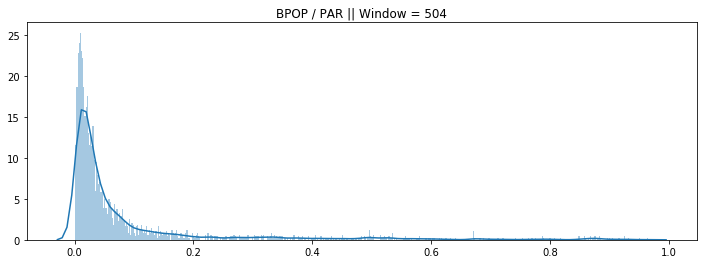

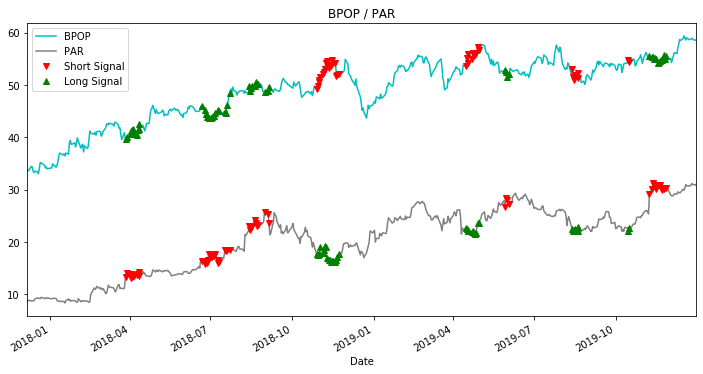

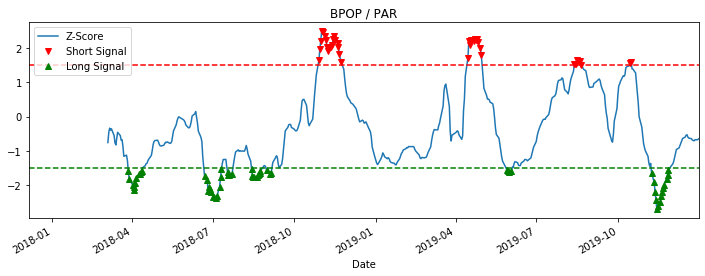

In [3]:
trigger = 1.5
w_t = 5
w_T = 60
pair_tickers = ['BPOP', 'PAR']
last_date = datetime(2020, 1, 1)
window = 252*3
numb_paths, w_p_value = 50, 252*2

pair_evaluation(pair_tickers, last_date, trigger, w_t, w_T, numb_paths ,window, w_p_value,'Y')

## Prueba Función de Identificación de Pares

Esta función utiliza como input una lista de activos, a partir de ella encontrará todos los posibles pares existentes (todos aquellos que pasen el test de cointegración para una ventana de tiempo determinada).

[['AAPL', 'DIA'], ['BA', 'MSFT'], ['DIA', 'MSFT'], ['RCL', 'TCBK'], ['VRSN', 'BA']]


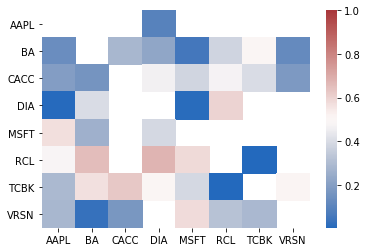

In [5]:
tckrs = ['VRSN','CACC','RCL','TCBK','AAPL','MSFT','BA','DIA']
tck_data = oget(tckrs,datetime(2019, 1, 1),datetime(2020, 1, 1))
all_clspx = tck_data[['Adj Close']].reset_index()
daily_px = all_clspx.pivot('Date', 'Ticker','Adj Close')

scores, pvalues, pairs = find_cointegrated_pairs(daily_px,252)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
#print(pvalues)
print(pairs)
tckrs.sort()
sns.heatmap(pvalues, xticklabels=tckrs, yticklabels=tckrs, cmap='vlag', mask = (pvalues >= 0.7))
plt.show();

## Prueba Función de Backtesting

Utiliza de input una lista de activos, hará uso de la función de identificación de pares, con el fin de identificar día a día que pares cumplen con ciertas condiciones necesarias para ser operados. Lleva un registro historico de las posiciones abiertas, cerradas, el efectivo disponible y el valor del portafolio.

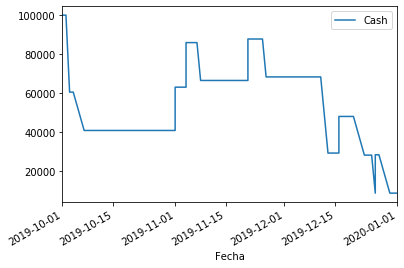

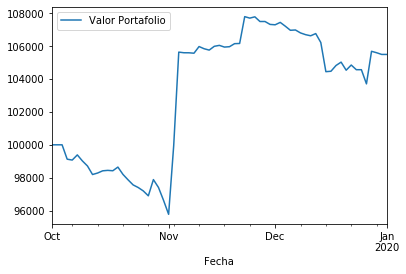

In [6]:
# BACKTESTING 
start = datetime(2019, 10, 1)  # datetime(2019, 8, 1)
end = datetime(2020, 1, 1)
tckrs = ['VRSN','CACC','RCL','TCBK','AAPL','MSFT','BA','DIA']
window_hist = 252
trigger = 1.96
lim_trigger = 2.5
stop_loss_trigger = 3.0
take_prof_trigger = 0.5
pos_size = .2
max_expo = 5
cash_0 = 100000

port_df1, cash_df1, open_ops1, closed_ops1 = bla(tckrs, start, end, window_hist, trigger, lim_trigger, stop_loss_trigger, take_prof_trigger, pos_size, max_expo, cash_0)
cash_df1.plot();
port_df1.plot();